# GACSE Workshop

In [7]:
from __future__ import print_function

In [34]:
import sys
sys.path.append('../build/')
sys.path.append('hand_eye_calibration/')

In [9]:
%pylab inline
np.set_printoptions(precision=4, suppress=True)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [10]:
import versor as vsr

In [11]:
from motor_estimation import MotorEstimationSolver

In [6]:
fig_width_pt =  332.89726               # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5.0)-1.0)/2.0       # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size = [fig_width,fig_height]
params = {
    'axes.labelsize': 9,
    'font.size': 9,
    "font.family": "serif",
    "font.serif": [],
    'legend.fontsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'text.latex.preamble':[r'\usepackage{amsmath}', r'\usepackage{bm}'],
    'figure.figsize': fig_size,
    'axes.linewidth': 0.5
}
matplotlib.rcParams.update(params)

## Ground truth motor

In [14]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
print(motor)

Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]


## Motor Estimation from Points

### Dataset generation

In [15]:
n_points = 10
sigma = 0.09
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() 
            for i in range(n_points)]
points_b = [point.spin(motor) for point in points_a]
points_b_noisy = [vsr.Vec(*(np.array(point)[:3] 
                            + sigma * np.random.randn(3))).null() 
                  for point in points_b]

### Estimate motor

In [16]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(estimated_motor, summary) = mes.solve()
print(summary['full_report'])


Solver Summary (v 1.12.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   30                       30

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          2.319964e+01
Final              

#### Check solution

In [10]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866 -0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
True


In [11]:
rtol = 1e-1
atol = 1e-9
print([np.abs(a - b) <= atol + rtol * np.abs(b) for a, b in zip(np.array(motor), np.array(estimated_motor))])
[np.abs(a - b) for a, b in zip(np.array(motor), np.array(estimated_motor))]

[True, True, True, True, True, True, True, True]


[6.1700866638148e-11,
 2.563232119880271e-11,
 1.0686934670545156e-10,
 4.1963751725613409e-11,
 7.3379746723389871e-11,
 1.1449008407993233e-11,
 1.8669882306809882e-10,
 2.6123520013854318e-11]

## Motor Estimation from Lines

### Dataset generation

In [17]:
lines_a = [vsr.Dll(vsr.Vec(*np.random.normal(0.0,0.8,3)),
                   vsr.Vec(*np.random.normal(0.0,0.8,3)))
          for i in range(10)]
lines_b = [line.spin(motor) for line in lines_a]

### Estimate motor using 6 residuals

$$ \arg \min_M \frac{1}{2} \sum_{i=1}^n \left| M \varLambda_{b_i} \tilde{M} - \varLambda_{a_i}  \right| $$

In [18]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_1 = mes.solve()
print(lin_summary_1['brief_report'])

Ceres Solver Report: Iterations: 5, Initial cost: 3.325778e+01, Final cost: 7.972394e-26, Termination: CONVERGENCE


#### Check solution

In [19]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  0.    -0.5   -0.    -0.683 -0.433 -0.183 -0.25 ]
True


### Estimate motor using 4 residuals

In [13]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_2 = mes.solve()
print(lin_summary_2['full_report'])

NameError: name 'lines_a' is not defined

#### Check solution

In [21]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.8661 -0.0001 -0.4999  0.     -0.6831 -0.4329 -0.1832 -0.2499]
False
True


In [22]:
rtol = 1e-5
atol = 1e-3
[np.abs(a - b) <= atol + rtol * np.abs(b) for a, b in zip(np.array(motor), np.array(estimated_motor))]

[True, True, True, True, True, True, True, True]

### Estimate motor using 2 residuals

In [23]:
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_norm_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
estimated_motor, lin_summary_3 = mes.solve()
print(lin_summary_3['full_report'])


Solver Summary (v 1.11.0-eigen-(3.2.8)-lapack-suitesparse-(4.4.4)-cxsparse-(3.1.4)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            10                       10
Residual                                   20                       20

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          2.812992e+01


#### Check solution

In [24]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  -0.0002 -0.5    -0.0001 -0.6832 -0.4329 -0.1829 -0.2498]
False
True


### Plots

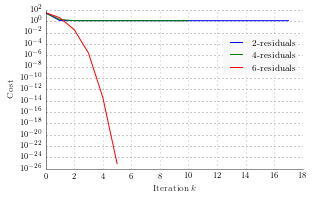

In [74]:
fig, ax = plt.subplots(1)

# ax.set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

ax.grid(True,which="both", color='0.5')
ax.set_axisbelow(True)

ax.plot([it['cost'] for it in lin_summary_3['iterations'] ], label=r"$2$-residuals")
ax.plot([it['cost'] for it in lin_summary_2['iterations'] ], label=r"$4$-residuals")
ax.plot([it['cost'] for it in lin_summary_1['iterations'] ], label=r"$6$-residuals")

ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)



# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.
light_grey = np.array([float(248)/float(255)]*3)
legend = ax.legend(frameon=True, scatterpoints=1, bbox_to_anchor=(0.9, 0.8), bbox_transform=plt.gcf().transFigure)
# legend = ax.legend(frameon=True, scatterpoints=1)

rect = legend.get_frame()

rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)

ax.set_yscale("log")

plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')


# plt.savefig('/Users/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_lines.pdf')

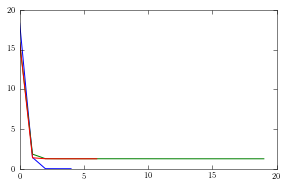

In [24]:
plt.figure(1)
# plt.subplot(311)
plt.plot([it['cost'] for it in lin_summary_1['iterations'] ])

# plt.subplot(312)
plt.plot([it['cost'] for it in lin_summary_2['iterations'] ])

# plt.subplot(313)
plt.plot([it['cost'] for it in lin_summary_3['iterations'] ])
plt.savefig('/Users/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_lines.pdf')

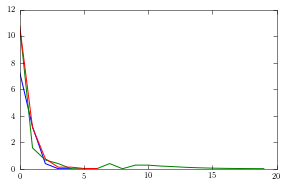

In [25]:
fig, ax = plt.subplots(1)
ax.plot([it['gradient_max_norm'] for it in lin_summary_1['iterations'] ])
ax.plot([it['gradient_max_norm'] for it in lin_summary_2['iterations'] ])
ax.plot([it['gradient_max_norm'] for it in lin_summary_3['iterations'] ])

## Motor Estimation from planes

### Dataset generation

In [27]:
n_planes = 10
planes_a = []
for i in range(10):
    dir_vec = np.random.normal(0.0, 0.8, 4)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    distance = np.random.normal(0.0, 0.8,1)
    arr = dir_vec + distance
    planes_a.append(vsr.Dlp(dir_vec[0],dir_vec[1],dir_vec[2],distance[0]))
planes_b = [plane.spin(motor) for plane in planes_a]

### Estimate motor using 2 residuals

In [28]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor_plane = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/24)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
#     mes.add_dual_plane_angle_error_residual_block(a,b.spin(noise_motor_plane))
    mes.add_dual_plane_angle_error_residual_block(a,b)

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 100
estimated_motor, pln_summary_1 = mes.solve()
print(pln_summary_1['brief_report'])

Ceres Solver Report: Iterations: 7, Initial cost: 5.673069e+01, Final cost: 1.250000e+00, Termination: CONVERGENCE


In [29]:
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-03))

[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
False
True


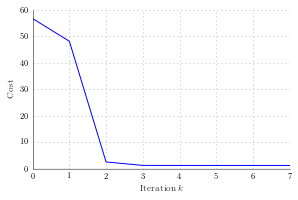

In [76]:
fig, ax = plt.subplots(1)

# ax.set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

ax.plot([it['cost'] for it in pln_summary_1['iterations'] ])

ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.

# light_grey = np.array([float(248)/float(255)]*3)
# legend = ax.legend(frameon=True, scatterpoints=1)
# rect = legend.get_frame()
# rect.set_facecolor(light_grey)
# rect.set_linewidth(0.0)

# ax.set_yscale('log')


ax.grid(True,which="both", color='0.5')
ax.set_axisbelow(True)

plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')

# plt.savefig('/Users/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_planes.pdf')

## Motor Estimation from tangents

### Dataset generation

In [30]:
n_tangents = 10
tangents_a = []
for i in range(n_tangents):
    dir_vec = np.random.normal(0.0, 0.8, 3)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    pos = np.random.normal(0.0, 0.8, 3)
    tangents_a.append(vsr.Tnv(vsr.Vec(*dir_vec)).spin(vsr.Vec(*pos).trs() * 
                                             vsr.Rot(1,0,0,0)))

tangents_b = [tangent.spin(motor) for tangent in tangents_a]

TypeError: Incompatible function arguments. The following argument types are supported:
    1. (Tnv, Vec) -> None


### Estimate motors using flags

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(tangents_a, tangents_b):
    dir_vec = np.random.normal(0.0, 0.8, 3)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    pos = np.random.normal(0.0, 0.01, 3)
    angle = np.random.normal(0.0, pi/1000., 1)
    noise_motor_tangent = vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*dir_vec).unduale() * angle[0])
    b = b.spin(noise_motor_tangent)
    mes.add_point_correspondences_residual_block(a.pnt(), b.pnt())
    mes.add_line_correspondences_residual_block(a.lin().dual(), b.lin().dual())
#     mes.add_tangent_vector_point_angle_error_residual_block(a,b)

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 200
em, summary = mes.solve()
print(motor)
print(em)
print(summary['brief_report'])

### Estimate motor

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(tangents_a, tangents_b):
    mes.add_tangent_vector_point_angle_error_residual_block(a,b)

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-8
mes.max_num_iterations = 2000
em, summary = mes.solve()
print(initial_motor)
print(motor)
print(em)
print(summary['full_report'])

## Motor Estimation from Circles

### Dataset generation

In [ ]:
n_circles = 5
circles_a = []
for i in range(n_circles):
    dir_vec = np.random.normal(0.0, 0.8, 3)
    dir_vec = dir_vec / np.linalg.norm(dir_vec)
    pos = np.random.normal(0.0, 0.8, 3)
    radius = np.random.normal(0.0, 0.8, 1)
    circles_a.append(vsr.Cir(vsr.Vec(*pos).null(), radius[0], 
                             vsr.Vec(*(dir_vec)).unduale()))

circles_b = [circle.spin(motor) for circle in circles_a]

### Estimate motor

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(circles_a, circles_b):
#     mes.add_point_correspondences_residual_block(a.pnt(), b.pnt())
    mes.add_dual_plane_angle_error_residual_block(a.pln().dual(), b.pln().dual())

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-6
mes.max_num_iterations = 2000
em, summary = mes.solve()
print(initial_motor)
print(motor)
print(em)
print(summary['full_report'])

## Motor Estimation from Spheres

### Dataset generation

In [ ]:
n_spheres = 5
spheres_a = []
for i in range(n_spheres):
    pos = np.random.normal(0.0, 0.8, 3)
    radius = np.random.normal(0.0, 0.8, 1)
    spheres_a.append(vsr.Sph(vsr.Vec(*pos).null(), radius[0]))
spheres_b = [sphere.spin(motor) for sphere in spheres_a]

### Estimate motor

In [ ]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(spheres_a, spheres_b):
    mes.add_point_correspondences_residual_block(a.pnt(),b.pnt())
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = 'DENSE_QR'
(estimated_motor, summary) = mes.solve()
print(summary['brief_report'])

## Motor Estimation from heterogeneous conformal objects

In [32]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)

noise_motor_plane = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)
noise_motor_lines = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
noise_motor_points = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,0,1) * (np.pi/100))

initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_angle_error_residual_block(a,b)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(a,b)
for a, b in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(a,b)
    
    

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
# mes.function_tolerance = 1e-8
mes.max_num_iterations = 100
em, summary_het = mes.solve()
print(initial_motor)
print(motor)
print(em)
print(np.array(motor))
print(np.array(estimated_motor))
print(np.allclose(np.array(motor), np.array(estimated_motor)))
print(np.allclose(np.array(motor), np.array(estimated_motor), 
                  rtol=1e-05, atol=1e-5))
print(summary_het['full_report'])

Mot: [ 1 0 0 0 0 0 0 0 ]
Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 0.87 5.3e-07 -0.5 -7.1e-07 -0.68 -0.43 -0.18 -0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
[ 0.866  0.    -0.5    0.    -0.683 -0.433 -0.183 -0.25 ]
False
True

Solver Summary (v 1.11.0-eigen-(3.2.8)-lapack-suitesparse-(4.4.4)-cxsparse-(3.1.4)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            30                       30
Residual                                  110                      110

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear 

In [33]:
motor = vsr.Vec(1,1,1).trs() * vsr.Rot(vsr.Biv(0,1,0) * np.pi/6.0)
noise_motor = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)

noise_motor_planes = vsr.Vec(0.05,0.05,0.05).trs() * vsr.Rot(vsr.Biv(1,0,0) * np.pi/100)
noise_motor_lines = vsr.Vec(-0.01,-0.01,-0.01).trs() * vsr.Rot(vsr.Biv(0,1,0) * (-np.pi/100))
noise_motor_points = vsr.Vec(0.1,0.1,0.1).trs() * vsr.Rot(vsr.Biv(0,0,1) * (np.pi/100))

initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(planes_a, planes_b):
    mes.add_dual_plane_angle_error_residual_block(a,b.spin(noise_motor_plane))
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(a,b.spin(noise_motor_lines))
for a, b in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(a,b.spin(noise_motor_points))
    
    

mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
# mes.function_tolerance = 1e-8
mes.max_num_iterations = 100
em, summary_het_noise = mes.solve()
print(initial_motor)
print(motor)
print(em)
print(summary_het_noise['full_report'])

Mot: [ 1 0 0 0 0 0 0 0 ]
Mot: [ 0.87 0 -0.5 0 -0.68 -0.43 -0.18 -0.25 ]
Mot: [ 0.87 -0.012 -0.49 -0.01 -0.72 -0.44 -0.19 -0.24 ]

Solver Summary (v 1.11.0-eigen-(3.2.8)-lapack-suitesparse-(4.4.4)-cxsparse-(3.1.4)-no_openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                            30                       30
Residual                                  110                      110

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                     

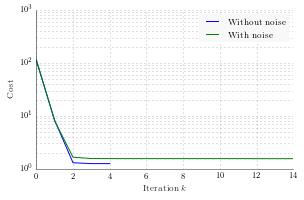

In [77]:
fig, ax = plt.subplots(1)

# ax.set_aspect('equal')
plt.set_cmap('gray')

almost_black = '#262626'
spines_to_remove = ['top', 'right']
for spine in spines_to_remove:
    ax.spines[spine].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

spines_to_keep = ['bottom', 'left']
for spine in spines_to_keep:
    ax.spines[spine].set_linewidth(0.5)
    ax.spines[spine].set_color(almost_black)
ax.xaxis.label.set_color(almost_black)
ax.yaxis.label.set_color(almost_black)

ax.plot([it['cost'] for it in summary_het['iterations'] ], label="Without noise")
ax.plot([it['cost'] for it in summary_het_noise['iterations']], label="With noise")


ax.title.set_color(almost_black)
ax.axhline(0, color=almost_black, linewidth=0.15)
ax.axvline(0, color=almost_black, linewidth=0.15)

# Remove the line around the legend box, and instead fill it with a light grey
# Also only use one point for the scatterplot legend because the user will 
# get the idea after just one, they don't need three.

light_grey = np.array([float(248)/float(255)]*3)
legend = ax.legend(frameon=True, scatterpoints=1)

rect = legend.get_frame()
rect.set_facecolor(light_grey)
rect.set_linewidth(0.0)

ax.set_yscale('log')

ax.grid(True,which="both", color='0.5')
ax.set_axisbelow(True)

plt.xlabel(r'Iteration $k$')
plt.ylabel(r'Cost')


plt.savefig('/Users/lars/Dropbox/Apps/ShareLaTeX/2016-gacse/figures/cost_heterogeneous.pdf')

## Hand Eye Calibration

### Set up motors

In [107]:
M_object_in_world = vsr.Vec(1.0,1.0,0.1).trs() * vsr.Biv(pi/4.0, 0.0,0.0).exp()
M_eye_in_hand = vsr.Vec(0.1, 0.2, 0.3).trs() * (vsr.Biv(0.0,1.0,0.0).unit() * pi/6.).exp()
M_eye_in_hand_initial = vsr.Vec(0.11, 0.24, 0.36).trs() * (vsr.Biv(1.0,1.0,0.0).unit() * (np.pi/5.)).exp()

### Dataset generation

In [119]:
def hand_eye_pose_pairs(M_object_in_world, M_eye_in_hand, n):
    pose_pairs = [
            (M_hand_in_world, 
             (M_eye_in_hand.rev() * M_hand_in_world.rev() * M_object_in_world))
            for M_hand_in_world in [vsr.Vec(*np.random.rand(3)).trs() *
                                    vsr.Rot(vsr.Biv(*np.random.rand(3)).unit() *
                                            np.random.rand() * np.pi)
                                    for i in range(n)]]

    As = [pose_pair[0] for pose_pair in pose_pairs]
    Bs = [pose_pair[1] for pose_pair in pose_pairs]

    LAs = []
    LBs = []
    for i in range(n):
        for j in range(i+1,n):
            LAs.append(As[j].rev() * As[i])
            LBs.append(Bs[j] * Bs[i].rev())
    return LAs, LBs

In [122]:
n_lines = 10
lines_a, lines_b = hand_eye_pose_pairs(M_object_in_world, M_eye_in_hand, n_lines)

### Estimate hand-eye motor 

In [71]:
mes = MotorEstimationSolver(M_eye_in_hand_initial)
for a, b in zip(lines_a, lines_b):
    mes.add_line_angle_distance_residual_block(a,b)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.function_tolerance = 1e-16
estimated_motor, summary = mes.solve()
# print(summary['full_report'])

#### Check solution

In [72]:
print(np.array(M_eye_in_hand))
print(np.array(estimated_motor))
print(np.allclose(np.array(M_eye_in_hand), np.array(estimated_motor)))

[ 0.866   0.     -0.5     0.     -0.1183 -0.0866 -0.1049 -0.05  ]
[ 0.866  -0.      0.5     0.      0.1183  0.0866  0.1049 -0.05  ]
False


### Real Experiment

In [73]:
import cPickle as pickle
import math3d as m3d

#### Dataset generation

In [41]:
rob_pose_list = pickle.load(open('../data/pose_list.dump'))
obj_pose_list = pickle.load(open('../data/obj_pose_list.dump'))
a_trfs = pickle.load(open('../data/as.dump'))
b_trfs = pickle.load(open('../data/bs.dump'))

In [42]:
rob_motors = [vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*axis).unduale() * angle / 2.)
              for pos, (axis, angle) in [(m3d.Transform(pose).pos, 
                                          m3d.Transform(pose).orient.axis_angle)
                                         for pose in rob_pose_list]]
obj_motors = [vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*axis).unduale() * angle / 2.)
              for pos, (axis, angle) in [(m3d.Transform(pose).pos, 
                                          m3d.Transform(pose).orient.axis_angle)
                                         for pose in obj_pose_list]]

In [81]:
n_lines = len(rob_motors)
lines_a = []
lines_b = []
for i in range(n_lines):
    for j in range(i+1,n_lines):
        lines_a.append(((rob_motors[j].rev() * rob_motors[i]).log() * 0.5).unit())
        lines_b.append(((obj_motors[j].rev() * obj_motors[i]).log() * 0.5).unit())

In [44]:
n_lines = len(a_trfs)
motors_a = [vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*axis).unduale() * angle / 2.)
              for pos, (axis, angle) in [(m3d.Transform(pose).pos, 
                                          m3d.Transform(pose).orient.axis_angle)
                                         for pose in a_trfs]]
motors_b = [vsr.Vec(*pos).trs() * vsr.Rot(vsr.Vec(*axis).unduale() * angle / 2.)
              for pos, (axis, angle) in [(m3d.Transform(pose).pos, 
                                          m3d.Transform(pose).orient.axis_angle)
                                         for pose in b_trfs]]
lines_a = [motor.log() for motor in motors_a]
lines_b = [motor.log() for motor in motors_b]

#### Estimate hand-eye motor

In [75]:
mes = MotorEstimationSolver(initial_motor)
for a, b in zip(lines_a, lines_b):
    mes.add_line_correspondences_residual_block(b,a)
#     mes.add_line_angle_distance_residual_block(b,a)
mes.set_parameterization('BIVECTOR_GENERATOR')
mes.linear_solver_type = "DENSE_QR"
mes.max_num_iterations = 25
mes.function_tolerance = 1e-12
estimated_motor, summary = mes.solve()
print(summary['full_report'])


Solver Summary (v 1.12.0-eigen-(3.2.92)-lapack-suitesparse-(4.4.6)-openmp)

                                     Original                  Reduced
Parameter blocks                            1                        1
Parameters                                  8                        8
Effective parameters                        6                        6
Residual blocks                           210                      210
Residual                                 1260                     1260

Minimizer                        TRUST_REGION

Dense linear algebra library            EIGEN
Trust region strategy     LEVENBERG_MARQUARDT

                                        Given                     Used
Linear solver                        DENSE_QR                 DENSE_QR
Threads                                     1                        1
Linear solver threads                       1                        1

Cost:
Initial                          1.056910e+03
Final              

In [76]:
print(estimated_motor)
print(m3d.Transform(estimated_motor.matrix()))

Mot: [ 0.004 -0.0055 -0.68 -0.74 -0.044 -0.047 0.053 -0.0072 ]
<Transform:
<Orientation: 
array([[ 0.0835, -0.9965,  0.0027],
       [-0.9964, -0.0835, -0.0134],
       [ 0.0136, -0.0015, -0.9999]])>
<Vector: (0.06106, 0.08873, 0.12802)>
>


#### Combination of estimates

In [77]:
bivectors = [np.array((r * estimated_motor * o.rev()).log()) 
             for r, o in zip(rob_motors, obj_motors)]
m = vsr.Dll(*np.average(bivectors,0)).exp()
print(m3d.Transform(m.matrix()))

<Transform:
<Orientation: 
array([[ 0.731 ,  0.0077,  0.6823],
       [-0.6824,  0.0042,  0.731 ],
       [ 0.0028, -1.    ,  0.0083]])>
<Vector: (-0.95963, -0.86260, 0.76400)>
>


#### Tsai Lenz Solver

In [78]:
from tsai_lens_calibration import TsaiLenzCalibrator

In [123]:
# pose_pairs = [(m3d.Transform(A), m3d.Transform(B)) 
#               for (A, B)  in zip(rob_pose_list, obj_pose_list)]
pose_pairs = [(m3d.Transform(A.matrix()), m3d.Transform(B.matrix())) 
              for (A, B)  in zip(lines_a, lines_b)]
tsai_lens = TsaiLenzCalibrator(pose_pairs)
tsai_lens.sensor_in_flange

<Transform:
<Orientation: 
array([[ 0.5  , -0.   , -0.866],
       [-0.   ,  1.   , -0.   ],
       [ 0.866,  0.   ,  0.5  ]])>
<Vector: (0.10000, 0.20000, 0.30000)>
>

#### Park Martin Solver

In [124]:
from park_martin import calibrate as park_martin_calibration
A, B = [], []
n_trfs = len(rob_pose_list)
for i in range(n_trfs):
    for j in range(i+1, n_trfs):
        A.append((m3d.Transform(rob_pose_list[j]).inverse * m3d.Transform(rob_pose_list[i])).array)
        B.append((m3d.Transform(obj_pose_list[j]).inverse * m3d.Transform(obj_pose_list[i])).array)
R,t = park_martin_calibration(A,B)
print(m3d.Transform(R,t))

<Transform:
<Orientation: 
array([[ 0.1051, -0.9945,  0.0021],
       [-0.9943, -0.1051, -0.0175],
       [ 0.0176, -0.0003, -0.9998]])>
<Vector: (0.04123, 0.09907, 0.14488)>
>


In [148]:
A = [p.array for p in np.array(pose_pairs)[:,0]]
B = [p.array for p in np.array(pose_pairs)[:,1]]
R,t = park_martin_calibration(A,B)
print(m3d.Transform(R,t))

<Transform:
<Orientation: 
array([[ 0.5  ,  0.   , -0.866],
       [ 0.   ,  1.   , -0.   ],
       [ 0.866,  0.   ,  0.5  ]])>
<Vector: (0.10000, 0.20000, 0.30000)>
>


In [136]:
def daniilidis_motor(LAs, LBs):
    Ds = []
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((8,8))
        for i in range(8):
            ei = vsr.Mot(0,0,0,0,0,0,0,0)
            ei[i] = 1.0
            D[:,i] = np.array(LA * ei - ei * LB)
        Ds.append(D[1:7,:].copy())
    
    Ds = np.array(Ds).reshape(-1,8)
    [U, s, Vt] = np.linalg.svd(Ds)

    v7 = Vt.T[:,-2].copy()
    v8 = Vt.T[:,-1].copy()
    
    v7 = np.array([-v7[0], v7[3], -v7[2], v7[1], v7[7],v7[4], v7[5], v7[6]])
    v8 = np.array([-v8[0], v8[3], -v8[2], v8[1], v8[7],v8[4], v8[5], v8[6]])
    
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]

    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])

    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1./val)
    lambda1 = s * lambda2
    
    m_arr = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]

    return vsr.Mot(*m_arr)

In [137]:
dm = daniilidis_motor(lines_b, lines_a)
print(dm)

Mot: [ -0.87 -3.3e-17 -0.5 -3.9e-17 -0.12 -0.087 -0.1 0.05 ]


In [138]:
print(m3d.Transform(dm.matrix()))

<Transform:
<Orientation: 
array([[ 0.5  ,  0.   ,  0.866],
       [-0.   ,  1.   ,  0.   ],
       [-0.866, -0.   ,  0.5  ]])>
<Vector: (-0.30981, -0.20000, -0.06340)>
>


In [139]:
print(M_eye_in_hand)

Mot: [ 0.87 0 -0.5 0 -0.12 -0.087 -0.1 -0.05 ]


In [140]:
print(m3d.Transform(M_eye_in_hand.matrix()))

<Transform:
<Orientation: 
array([[ 0.5  ,  0.   , -0.866],
       [ 0.   ,  1.   ,  0.   ],
       [ 0.866,  0.   ,  0.5  ]])>
<Vector: (0.10000, 0.20000, 0.30000)>
>


In [114]:
print(estimated_motor * estimated_motor.rev())
print(dm * dm.rev())

Mot: [ 1 0 0 0 3.5e-18 4.3e-18 -7e-18 4.3e-17 ]
Mot: [ 1 0 1.6e-33 -1.5e-33 2.2e-17 0 5.7e-18 -1.4e-17 ]


In [86]:
bivectors = [np.array((r * daniilidis_motor * o.rev()).log()) 
             for r, o in zip(rob_motors, obj_motors)]
m = vsr.Dll(*np.average(bivectors,0)).exp()
print(m3d.Transform(m.matrix()))

<Transform:
<Orientation: 
array([[ 0.7348,  0.0333,  0.6774],
       [-0.6776, -0.0086,  0.7354],
       [ 0.0303, -0.9994,  0.0162]])>
<Vector: (-0.98140, -0.88927, 0.79542)>
>
